In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2

# 1. Setup

In [2]:
# Workaround: set environment vars BEFORE importing libraries that may load OpenMP runtimes
# This may avoid the libiomp5md.dll duplicate-initialization crash seen when plotting.
import os
# Unsafe workaround to allow duplicate OpenMP runtimes (makes the process continue instead of crashing)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# Also limit OpenMP threads to 1 to reduce runtime conflicts
os.environ['OMP_NUM_THREADS'] = '1'
# Note: restart the kernel after this change for it to take full effect if other modules were already loaded.

In [3]:
import numpy as np
import pandas as pd
import torch 
from torch.utils.data import DataLoader

from anytree import Node, RenderTree

import requests

from matplotlib import pyplot as plt 

from mermaidseg.datasets.dataset import MermaidDataset, Mermaid15Dataset, CoralNetDataset
from mermaidseg.visualization import get_legend_elements

c:\Users\Admin\anaconda3\envs\ai-workshop\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Data

In [4]:
df_labels = pd.read_excel("../data/CoralNetMermaidMatchedCoralFocusModel2Reassign_master.xlsx")

In [5]:
df_labels

,CoralNetID,CoralNetName,Default short code,Functional group,Public sources using,Public annotation count,NewCoralNetID,Top100,MERMAID_BA,BA_AssignNotes,...,CoralFocusLabel,precision_CoralFocusModel,recall_CoralFocusModel,f1-score_CoralFocusModel,support_CoralFocusModel,CoralFocus2Label,CoralFocus3Label,CoralFocus3_BaID,CoralFocus3_GfID,Unnamed: 44
0,82,Turf algae,Turf,Algae,321,5496896,82,1,Turf algae,NaN,...,Turf algae,0.605677,0.356949,0.449179,9923,Turf algae,Turf algae,20090bf4-868e-431b-974c-ab9be5bbdb5f,NaN,NaN
1,84,Sand,Sand,Soft Substrate,418,1882701,84,1,Sand,NaN,...,Sand,0.749551,0.706228,0.727245,10052,Sand,Sand,b76bca12-884b-4404-bb9f-97d505b0fe58,NaN,NaN
2,1348,CRED-Turf growing on hard substrate,*TURFH,Hard Substrate,18,1216402,82,1,Turf algae,NaN,...,Turf algae,0.605677,0.356949,0.449179,9923,Turf algae,Turf algae,20090bf4-868e-431b-974c-ab9be5bbdb5f,NaN,NaN
3,101,CCA (crustose coralline algae),CCA,Algae,333,1088719,101,1,Crustose coralline algae,NaN,...,Crustose coralline algae,0.844473,0.904446,0.873431,132291,Crustose coralline algae,Crustose coralline algae,f4df7abd-3d51-42fb-8cab-5102b95fad8e,NaN,NaN
4,81,Macroalgae,MAL,Algae,183,596756,81,1,Macroalgae,NaN,...,Macroalgae,0.828518,0.885396,0.856013,124455,Macroalgae,Macroalgae,09226989-50e7-4c40-bd36-5bcef32ee7a1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,3531,Sandalolitha,SANDALTH,Hard coral,12,1,76,0,Sandalolitha,NaN,...,Fungiidae,0.856140,0.753086,0.801314,648,Fungiidae,Fungiidae,2085b131-1ed4-4b5b-9129-fb655a7659bd,NaN,no match
707,7007,Hannia,hannia,Other,12,1,1647,0,Unknown,Could not find on WoRMS,...,Other,0.698113,0.336364,0.453988,110,Other,Remove,NaN,NaN,no match
708,390,Mycetophyllia,Mycetophy,Hard coral,21,1,390,0,Mycetophyllia,NaN,...,Mussidae,0.582192,0.381166,0.460705,223,Mussidae,Mussidae,e5e686e5-5f55-499c-ab8e-dc8aa79db5c4,NaN,no match
709,2457,Helioseris cucullata,HeCuc,Hard coral,22,1,2457,0,Helioseris cucullata,NaN,...,Agariciidae,0.632479,0.378517,0.473600,391,Agariciidae,Agariciidae,3151a2f4-1f93-41c6-998a-3b5bcbb27717,NaN,no match


In [6]:
labelset = {}

## 2.1 Initialize Benthic Labelset

In [7]:
labelset["benthic"] = df_labels["MERMAID_BA"].unique().tolist()
labelset["benthic"] = [lab for lab in labelset["benthic"] if (lab != "Remove" and lab != "Scapophyllia")] # Scapophyllia is currently not in the mapping for some reason
labelset["benthic"].sort()

In [8]:
len(labelset["benthic"])

304

In [9]:
labelset

{'benthic': ['Acanthaster planci',
  'Acanthastrea',
  'Acanthophora spicifera',
  'Acetabularia',
  'Acropora',
  'Acropora cervicornis',
  'Acropora cytherea',
  'Acropora humilis',
  'Acropora muricata',
  'Acropora palmata',
  'Acropora prolifera',
  'Acroporidae',
  'Agaricia',
  'Agaricia agaricites',
  'Agaricia fragilis',
  'Agaricia grahamae',
  'Agaricia humilis',
  'Agaricia lamarcki',
  'Agaricia tenuifolia',
  'Agariciidae',
  'Agelas',
  'Alcyonacea',
  'Alveopora',
  'Amansia',
  'Amphiroa',
  'Anemone',
  'Antipatharia',
  'Aplysina',
  'Aplysinidae',
  'Ascidian',
  'Asparagopsis',
  'Asparagopsis taxiformis',
  'Astrea',
  'Astreopora',
  'Avrainvillea',
  'Bare substrate',
  'Bivalvia',
  'Blastomussa',
  'Bleached coral',
  'Bleached soft coral',
  'Briareum',
  'Bryozoan',
  'Caulastraea',
  'Caulerpa',
  'Caulerpa racemosa',
  'Chlorodesmis',
  'Chondrilla',
  'Chrysocystis fragilis',
  'Cladiella',
  'Cladophora',
  'Codium',
  'Coeloseris',
  'Colpomenia',
  'Co

## 2.2 Initialize Growth Form Labelset

In [10]:
labelset["growth_form"] = df_labels["MERMAID_GF"].unique().tolist()
labelset["growth_form"] = [lab for lab in labelset["growth_form"] if (lab != "Remove" and lab!= "?" and lab is not np.nan)] 
labelset["growth_form"].sort()

In [11]:
labelset["growth_form"]

['Arborescent',
 'Branching',
 'Columnar',
 'Corymbose',
 'Digitate',
 'Encrusting',
 'Foliose',
 'Massive',
 'Mushroom coral',
 'Plates or tables',
 'Submassive']

## 2.3 Hierarchical Mapping

In [12]:
response = requests.get("https://api.datamermaid.org/v1/benthicattributes/")
data = response.json()
benthic_attributes = data['results']

# Keep fetching next pages while there is a 'next' URL
while data['next']:
    response = requests.get(data['next'])
    data = response.json()
    benthic_attributes.extend(data['results'])

In [13]:
hierarchy_id_dict = {}
id2name_dict = {}
for attr in benthic_attributes:
    node_id = attr['id']
    parent_id = attr['parent']
    hierarchy_id_dict[node_id] = parent_id
    id2name_dict[node_id] = attr['name']

In [14]:
hierarchy_dict = {id2name_dict.get(node_id, None): id2name_dict.get(parent_id, None) for node_id, parent_id in hierarchy_id_dict.items()}

In [15]:
# Sanity check for Nones in keys and values (which are fine if the keys are top level categories)
sum(1 for k in hierarchy_dict.keys() if k is None), sum(1 for k in hierarchy_dict.values() if k is None)

(0, 12)

In [16]:
for label in labelset["benthic"]:
    if label not in hierarchy_dict:
        print(f"Label '{label}' not found in hierarchy_dict")

### Example Benthic Test

In [17]:
label_oi = "Acanthophora spicifera"

In [18]:
label_tmp = label_oi
while label_tmp in hierarchy_dict:
    label_tmp = hierarchy_dict[label_tmp]
    print(f"{label_oi} -> {label_tmp}")

Acanthophora spicifera -> Acanthophora
Acanthophora spicifera -> Macroalgae
Acanthophora spicifera -> None


In [19]:
def generate_hierarchy_path(label, hierarchy_dict):
    path = [label]
    label_tmp = label
    while label_tmp in hierarchy_dict and hierarchy_dict[label_tmp] is not None:
        label_tmp = hierarchy_dict[label_tmp]
        path.append(label_tmp)
    return path

In [20]:
generate_hierarchy_path(label_oi, hierarchy_dict)

['Acanthophora spicifera', 'Acanthophora', 'Macroalgae']

# 3. Concept Mapping

## 3.1 Benthic

In [164]:
# Option 1 - Initialize Benthic Concept Set - Based on all concepts found in the defined Mermaid benthic labels
benthic_concept_set = set()
for label in labelset["benthic"]:
    benthic_path = generate_hierarchy_path(label, hierarchy_dict)
    for concept in benthic_path:
        # if concept in benthic_concept_set:
        benthic_concept_set.add(concept)
benthic_concept_set = list(benthic_concept_set)
benthic_concept_set.sort()

In [ ]:
# # Option 2 - Initialize Benthic Concept Set - With all unique labels in the hierarchy
# benthic_concept_set = set(hierarchy_dict.keys())
# benthic_concept_set.sort()

In [109]:
# ## This does not currently work as there are some labels in the hierarchy that are not in the mapping
# # Initialize Benthic Concept Set - With all unique labels in the hierarchy excluding leaves in the hierarchy but including top level categories who might not have any children
# parents = {p for p in hierarchy_dict.values() if p is not None}
# top_level_categories = {n for n, p in hierarchy_dict.items() if p is None}
# hierarchy_leaves = sorted([n for n in hierarchy_dict.keys() if n not in parents])
# print(f"Found {len(parents)} parents, {len(hierarchy_leaves)} leaves and {len(top_level_categories)} top-level categories")
# benthic_concept_set = sorted(parents.union(top_level_categories))

In [165]:
benthic_concept_matrix = pd.DataFrame(0, index=labelset["benthic"], columns=benthic_concept_set)

In [166]:
benthic_concept_matrix.shape

(304, 360)

In [167]:
for label in labelset["benthic"]:
    benthic_path = generate_hierarchy_path(label, hierarchy_dict)
    for concept in benthic_path:
        # if concept in benthic_concept_set:
        benthic_concept_matrix.at[label, concept] = 1

In [168]:
benthic_concept_matrix

,Acanthaster planci,Acanthastrea,Acanthophora,Acanthophora spicifera,Acetabularia,Acropora,Acropora cervicornis,Acropora cytherea,Acropora humilis,Acropora muricata,...,Udotea,Ulva,Unknown,Valonia,Ventricaria,"Worms, sabellid",Wrangelia,Xenia,Xeniidae,Zoanthid
Acanthaster planci,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Acanthastrea,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Acanthophora spicifera,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Acetabularia,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Acropora,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Worms, sabellid",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Wrangelia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Xenia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Xeniidae,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [169]:
print(f"Number of concepts with zero related labels in benthic_concept_matrix: {(benthic_concept_matrix.sum(axis=0)==0).sum()}")

Number of concepts with zero related labels in benthic_concept_matrix: 0


In [170]:
## Sanity Check - Test whether number of concept is accurate
for label in labelset["benthic"]:
    benthic_path = generate_hierarchy_path(label, hierarchy_dict)
    n_concepts = benthic_concept_matrix.loc[label].sum()
    assert n_concepts == len(benthic_path), f"Mismatch for label {label}: {n_concepts} != {len(benthic_path)}"

In [171]:
benthic_concept_matrix.sum(axis=0).sort_values(ascending=False).head()

Hard coral             165
Macroalgae              57
Other invertebrates     35
Soft coral              26
Agariciidae             19
dtype: int64

In [172]:
benthic_concept_matrix.sum(axis=1).sort_values(ascending=False).head()

Heliopora coerulea      5
Lobactis scutaria       5
Spyridia filamentosa    4
Solenastrea hyades      4
Tubastraea coccinea     4
dtype: int64

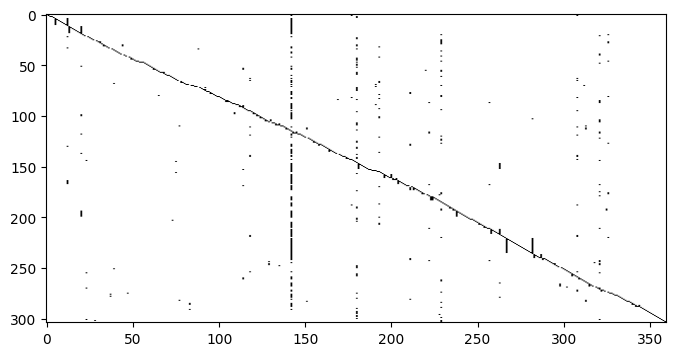

In [173]:
fig, ax = plt.subplots(figsize=(8,4))
ax.imshow(benthic_concept_matrix.values, aspect='auto', cmap='Greys')
plt.show()

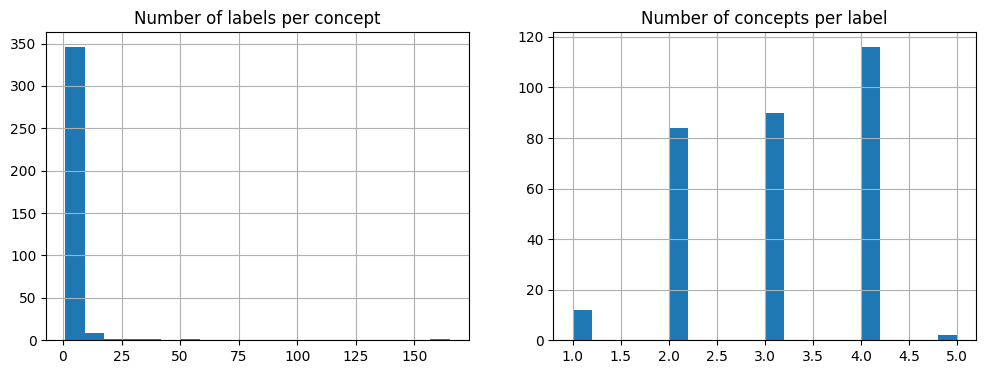

In [131]:
fig, ax = plt.subplots(figsize=(12,4), ncols = 2)
benthic_concept_matrix.sum(axis=0).hist(ax=ax[0], bins=20)
ax[0].set_title("Number of labels per concept")
benthic_concept_matrix.sum(axis=1).hist(ax=ax[1], bins=20)
ax[1].set_title("Number of concepts per label")
plt.show()

## 3.2 Growth Form 

In [175]:
growth_form_concept_set = labelset["growth_form"]
growth_form_concept_set.sort()

In [176]:
growth_form_concept_matrix = pd.DataFrame(0, index=labelset["growth_form"], columns=growth_form_concept_set)

In [177]:
# The growth form concepts is just a diagonal matrix or a one-hot encoding since as of now we have no hierarchy
for label in labelset["growth_form"]:
    growth_form_concept_matrix.at[label, label] = 1

# 3.3 Apply to Labels

In [178]:
df_labels.head()

,CoralNetID,CoralNetName,Default short code,Functional group,Public sources using,Public annotation count,NewCoralNetID,Top100,MERMAID_BA,BA_AssignNotes,...,CoralFocusLabel,precision_CoralFocusModel,recall_CoralFocusModel,f1-score_CoralFocusModel,support_CoralFocusModel,CoralFocus2Label,CoralFocus3Label,CoralFocus3_BaID,CoralFocus3_GfID,Unnamed: 44
0,82,Turf algae,Turf,Algae,321,5496896,82,1,Turf algae,NaN,...,Turf algae,0.605677,0.356949,0.449179,9923,Turf algae,Turf algae,20090bf4-868e-431b-974c-ab9be5bbdb5f,NaN,NaN
1,84,Sand,Sand,Soft Substrate,418,1882701,84,1,Sand,NaN,...,Sand,0.749551,0.706228,0.727245,10052,Sand,Sand,b76bca12-884b-4404-bb9f-97d505b0fe58,NaN,NaN
2,1348,CRED-Turf growing on hard substrate,*TURFH,Hard Substrate,18,1216402,82,1,Turf algae,NaN,...,Turf algae,0.605677,0.356949,0.449179,9923,Turf algae,Turf algae,20090bf4-868e-431b-974c-ab9be5bbdb5f,NaN,NaN
3,101,CCA (crustose coralline algae),CCA,Algae,333,1088719,101,1,Crustose coralline algae,NaN,...,Crustose coralline algae,0.844473,0.904446,0.873431,132291,Crustose coralline algae,Crustose coralline algae,f4df7abd-3d51-42fb-8cab-5102b95fad8e,NaN,NaN
4,81,Macroalgae,MAL,Algae,183,596756,81,1,Macroalgae,NaN,...,Macroalgae,0.828518,0.885396,0.856013,124455,Macroalgae,Macroalgae,09226989-50e7-4c40-bd36-5bcef32ee7a1,NaN,NaN


In [179]:
concept_matrix = []
index_names = []
column_names = list(benthic_concept_matrix.columns) + list(growth_form_concept_matrix.columns)
for i, df_labels_row in df_labels.iterrows():

    benthic_attribute_row = df_labels_row["MERMAID_BA"]
    growth_form_row = df_labels_row["MERMAID_GF"]
    ba_gf_row = df_labels_row["ba_gf"]
    index_names.append(ba_gf_row)
    if benthic_attribute_row in benthic_concept_matrix.index:
        benthic_one_hot = benthic_concept_matrix.loc[benthic_attribute_row, :].values
    else:
        benthic_one_hot = np.zeros(len(benthic_concept_matrix.columns))

    if growth_form_row in growth_form_concept_matrix.index:
        growth_form_one_hot = growth_form_concept_matrix.loc[growth_form_row, :].values
    else: 
        growth_form_one_hot = np.zeros(len(growth_form_concept_matrix.columns))
    concept_vector = np.concatenate([benthic_one_hot, growth_form_one_hot])
    concept_matrix.append(concept_vector)
concept_matrix = pd.DataFrame(concept_matrix, index=index_names, columns=column_names)
concept_matrix = concept_matrix.drop_duplicates()

In [180]:
concept_matrix

,Acanthaster planci,Acanthastrea,Acanthophora,Acanthophora spicifera,Acetabularia,Acropora,Acropora cervicornis,Acropora cytherea,Acropora humilis,Acropora muricata,...,Branching,Columnar,Corymbose,Digitate,Encrusting,Foliose,Massive,Mushroom coral,Plates or tables,Submassive
Turf algae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sand,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Crustose coralline algae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Macroalgae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bare substrate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pavona maldivensis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pavona cactus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sponge Arborescent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mycetophyllia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [181]:
# Check if there are 0 rows or columns
np.sort(np.sum(concept_matrix, axis=0))[:5], np.sort(np.sum(concept_matrix, axis=1))[:5]

(array([1., 1., 1., 1., 1.]), array([0., 1., 1., 1., 1.]))

In [184]:
concept_matrix.sum(axis=1).sort_values(ascending=True).head()

Scapophyllia                0.0
Turf algae                  1.0
Crustose coralline algae    1.0
Sand                        1.0
Bare substrate              1.0
dtype: float64